In [2]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

import xgboost as xgb


## Data Cleaning and Exploratory Data Analysis

In [3]:
# read the csv properly
df = pd.read_csv('train.csv')

#Appending test.csv too
test_df = pd.read_csv('test.csv')
#df = test_df_temp.append(df, ignore_index=True)

df.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/2004,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/2014,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/2012,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/2009,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [4]:
# Have a overal view of the dataset
# look at the shape of the df
print(df.shape)
# look at the types of columns
print('\n', df.dtypes)



(3000, 23)

 id                         int64
belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
Keywords                  object
cast                      object
crew                      object
revenue                    int64
dtype: object


### Handling missing data

In [5]:
# look at what columns contain missing values and how many
print(df.isna().sum()[df.isna().sum() !=0])

belongs_to_collection    2396
genres                      7
homepage                 2054
overview                    8
poster_path                 1
production_companies      156
production_countries       55
runtime                     2
spoken_languages           20
tagline                   597
Keywords                  276
cast                       13
crew                       16
dtype: int64


A nil value in "belongs_to_collection" column means the movie is not part of any collection

In [6]:
# replacing the empty values in "belongs_to_collection" to zero
df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: 0 if pd.isna(x) else x)

A nil value in "homepage" column means the movie has no homepage

In [7]:
# Create a new column indicating whether the movie has a homepage or not
df['with_homepage'] = df['homepage'].apply(lambda x: 0 if pd.isna(x) else 1)
# drop the homepage column because that is not relevant now
df = df.drop('homepage',axis=1)

In [8]:
df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'runtime', 'spoken_languages', 'status', 'tagline',
       'title', 'Keywords', 'cast', 'crew', 'revenue', 'with_homepage'],
      dtype='object')

In [9]:
# removing rows with empty values in other columns
df = df.dropna()

Take a look at budget and runtime

In [10]:
print(df['budget'].value_counts())
print(df['runtime'].value_counts())

0           433
15000000     65
40000000     64
25000000     63
20000000     61
           ... 
747000        1
5             1
65000         1
1750000       1
1135654       1
Name: budget, Length: 319, dtype: int64
100.0    73
105.0    69
90.0     66
98.0     63
97.0     63
         ..
179.0     1
212.0     1
162.0     1
165.0     1
182.0     1
Name: runtime, Length: 125, dtype: int64


We found that there are 433 movies with zero budget. That does not make sense. So we impute them using average budget

In [11]:
# The mean budget of movie with budget information
mean_budget = df[df['budget']!=0].budget.mean()
# Replacing movies with zero budget with the mean budget
df['budget'] = df['budget'].apply(lambda x: mean_budget if x==0 else x)

After cleaning the dataset, we ended up with a dataset with over 2,200 samples

In [12]:
df_cleaned = df
df_cleaned.shape

(2229, 23)

## Transforming the JSON objects in the CSV to a proper python object

In [13]:
# Convert string columns to proper python object
string_cols = ['belongs_to_collection', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']


def convert(df, cols=string_cols):
    for col in cols:
        df[col] = df[col].apply(lambda x: x if x==0 
                                else ast.literal_eval(x))
    return df

df_treated = convert(df_cleaned)


### Whether the movie belongs to a collection or not

In [14]:
# For belongs_to_collection col, actually missing value represents Nil

df_treated['collection_or_not'] = df_treated['belongs_to_collection'].apply(lambda x: 0 if x==0 else 1)

0    76.62629
1    23.37371
Name: collection_or_not, dtype: float64


Text(0.5, 1.0, 'Proportion of movies that are in a collection')

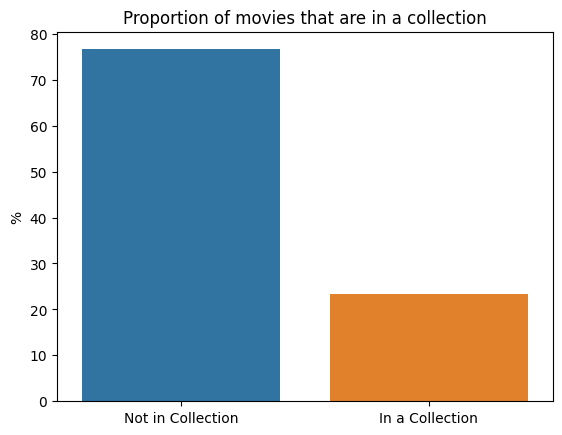

In [15]:
# % of our training movies belongs to a collection
collection_proportion = df_treated['collection_or_not'].value_counts(normalize=True)*100
print(collection_proportion)
sns.barplot(x=collection_proportion.index,
            y=collection_proportion.values)
plt.xticks([0,1],['Not in Collection','In a Collection'])
plt.ylabel('%')
plt.title('Proportion of movies that are in a collection')


Create a new columne with the name of the Collection that the movie belongs to

In [16]:
df_treated['collection_name'] = df_treated['belongs_to_collection'].apply(lambda x: 0 if x==0 else x[0]['name'])

### How many kinds of genres are there?

In [17]:
# take a quick look at the col
df_treated['genres'][:5]

0                       [{'id': 35, 'name': 'Comedy'}]
1    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                        [{'id': 18, 'name': 'Drama'}]
8    [{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...
9    [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...
Name: genres, dtype: object

We can see that some movies belong to only 1 genre while some belongs to multiple genres.

Lets see what is the maximum number of genres a movie can be in

3    723
2    689
1    381
4    319
5     96
6     18
7      3
Name: genres, dtype: int64


Text(0.5, 1.0, 'Distribution of movie genres')

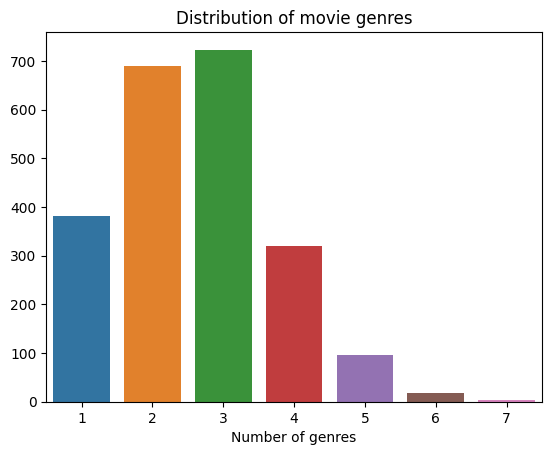

In [18]:
num_genres = df_treated['genres'].apply(lambda x: len(x)).value_counts()
print(num_genres)
sns.barplot(x=num_genres.index,
            y=num_genres.values)
plt.xlabel('Number of genres')
plt.title('Distribution of movie genres')

What are the unique genres?

In [19]:
genre_list = []

for i, row in df_treated.iterrows():
    for genres in row['genres']:
        genre_list.append(genres['name'])
    
genre_set = set(genre_list)
genre_set

{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western'}

In [20]:
# Creating a genre_name column for easy classification
def genre(col):
    gen_list = []
    for i in col:
        gen_list.append(i['name'])
    return gen_list

df_treated['genres_name'] = df_treated['genres'].apply(lambda x: genre(x))

In [21]:
# Creating a column for each genre
for i in list(genre_set):
    df_treated['genre_'+str(i)]=df_treated['genres_name'].apply(lambda x: 1 if i in x else 0)


In [22]:
# Counting the number of genres a movie belongs to
df_treated['genres_count'] = df_treated['genres_name'].apply(lambda x: len(x))

### Exploring the popularity score column

In [23]:
# look at the descriptive statistics of the column
df_treated.popularity.describe()

count    2229.000000
mean        9.691973
std        12.043572
min         0.007294
25%         5.772293
50%         8.364201
75%        11.552956
max       287.253654
Name: popularity, dtype: float64

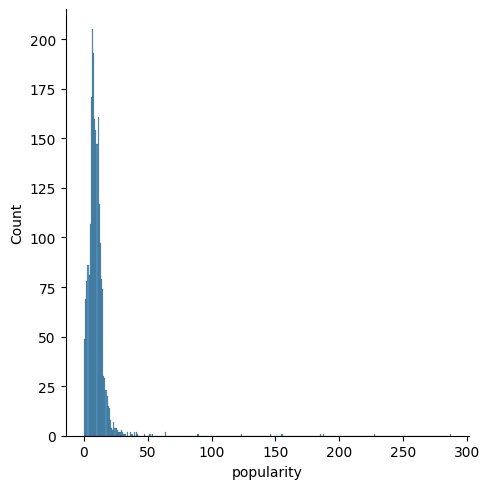

In [24]:
sns.displot(df_treated.popularity)

### Exploring the production companies

We can see that there are movies which are produced by only 1 company, but there are also movies that are produced by more than one companies. Lets find out:

2     585
1     540
3     480
4     260
5     147
6      94
7      51
8      36
9      20
11      6
10      5
16      1
12      1
14      1
17      1
15      1
Name: production_companies, dtype: int64


Text(0.5, 1.0, 'Distribution of number of production companies')

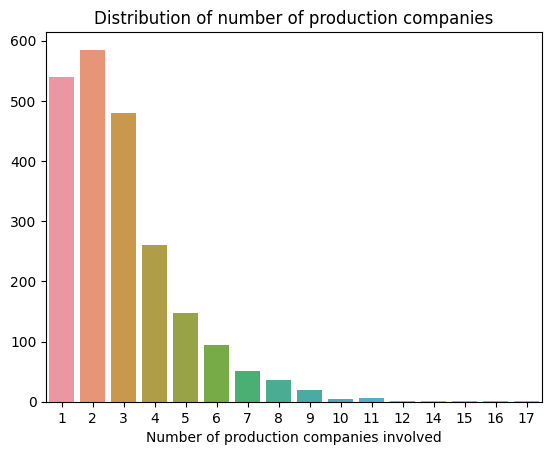

In [25]:
num_prod_companies = df_treated['production_companies'].apply(lambda x: len(x)).value_counts()
print(num_prod_companies)
sns.barplot(x=num_prod_companies.index,
            y=num_prod_companies.values)
plt.xlabel('Number of production companies involved')
plt.title('Distribution of number of production companies')

In [26]:
producer_list = []

for i, row in df_treated.iterrows():
    for producer in row['production_companies']:
        producer_list.append(producer['name'])
    
producer_set = set(producer_list)
producer_set

producer_list = list(producer_set)
print("There are {} unique production companies in total".format(len(producer_list)))

There are 2880 unique production companies in total


Lets just focus on the major production companies:

In [27]:
# Creating a prod_name column first
def prod(col):
    prod_list = []
    for i in col:
        prod_list.append(i['name'])
    return prod_list

df_treated['prod_company_name'] = df_treated['production_companies'].apply(lambda x: prod(x))

In [28]:
# Find out the top 15 production companies that produced the most movies
total_prod_companies = []
for i,row in df_treated.iterrows():
    for x in row['prod_company_name']:
        total_prod_companies.append(x)
    
Counter(total_prod_companies).most_common(15)

[('Warner Bros.', 184),
 ('Universal Pictures', 170),
 ('Paramount Pictures', 147),
 ('Twentieth Century Fox Film Corporation', 123),
 ('Columbia Pictures', 83),
 ('Metro-Goldwyn-Mayer (MGM)', 73),
 ('New Line Cinema', 67),
 ('Walt Disney Pictures', 58),
 ('Columbia Pictures Corporation', 55),
 ('Touchstone Pictures', 52),
 ('TriStar Pictures', 45),
 ('Relativity Media', 44),
 ('United Artists', 39),
 ('Village Roadshow Pictures', 36),
 ('Miramax Films', 34)]

In [29]:
# Counting the number of production companies a movie is produced
df_treated['prod_company_count'] = df_treated['prod_company_name'].apply(lambda x: len(x))

### Exploring the production countries

1    1654
2     418
3      94
4      47
5      15
8       1
Name: production_countries, dtype: int64


Text(0.5, 1.0, 'Distribution of number of production countries')

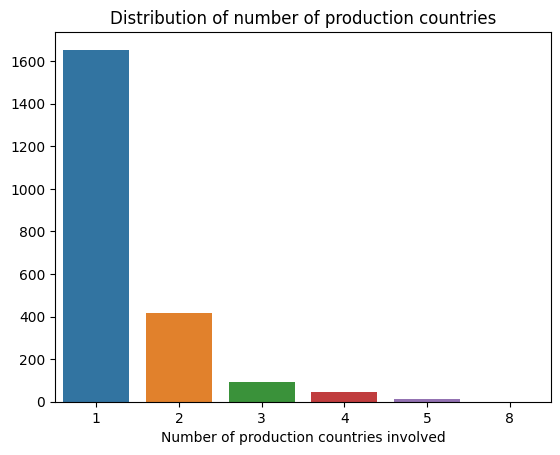

In [30]:
num_prod_countries = df_treated['production_countries'].apply(lambda x: len(x)).value_counts()
print(num_prod_countries)
sns.barplot(x=num_prod_countries.index,
            y=num_prod_countries.values)
plt.xlabel('Number of production countries involved')
plt.title('Distribution of number of production countries')

In [31]:
country_list = []

for i, row in df_treated.iterrows():
    for country in row['production_countries']:
        country_list.append(country['name'])
    
country_set = set(country_list)
country_set

country_list = list(country_set)
print("There are {} unique production countries in total".format(len(country_list)))

There are 63 unique production countries in total


In [32]:
# Creating a country_name column first
def country(col):
    country_list = []
    for i in col:
        country_list.append(i['name'])
    return country_list

df_treated['prod_country_name'] = df_treated['production_countries'].apply(lambda x: country(x))

In [33]:
# Find out the top 10 production countries that produced the most movies
total_country = []
for i,row in df_treated.iterrows():
    for x in row['prod_country_name']:
        total_country.append(x)
    
Counter(total_country).most_common(15)

[('United States of America', 1924),
 ('United Kingdom', 308),
 ('France', 141),
 ('Germany', 130),
 ('Canada', 98),
 ('Australia', 50),
 ('Italy', 41),
 ('Japan', 37),
 ('Spain', 31),
 ('Hong Kong', 22),
 ('China', 20),
 ('India', 19),
 ('Ireland', 15),
 ('New Zealand', 13),
 ('Russia', 13)]

In [34]:
# Counting the number of production countries a movie is produced
df_treated['prod_country_count'] = df_treated['prod_country_name'].apply(lambda x: len(x))

### Exploring the Release Date

In [35]:
df_treated['release_date'] = pd.to_datetime(df_treated['release_date'])

In [36]:
df_treated['release_date'][:10]

0    2015-02-20
1    2004-08-06
2    2014-10-10
8    1996-02-16
9    2003-04-16
10   1976-11-21
11   1987-07-10
12   1999-09-15
13   2005-03-04
14   2002-06-20
Name: release_date, dtype: datetime64[ns]

In [37]:
# Creating columns with respect to release year, month, day and days of the wek
df_treated['release_year'] = df_treated['release_date'].dt.year
df_treated['release_month'] = df_treated['release_date'].dt.month
df_treated['release_day'] = df_treated['release_date'].dt.day
df_treated['release_weekday'] = df_treated['release_date'].dt.weekday

In [38]:
# Sanity check
df_treated['release_year'].value_counts().sort_index(ascending=False)

2072    4
2071    6
2070    3
2069    3
2068    2
       ..
1936    1
1935    1
1933    1
1932    2
1931    1
Name: release_year, Length: 114, dtype: int64

Its clear that some of the release date has input issues! Take a look at those movies:

In [39]:
df_treated[df_treated['release_year']==2072]

,id,belongs_to_collection,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,with_homepage,collection_or_not,collection_name,genres_name,genre_Adventure,genre_Documentary,genre_Thriller,genre_Science Fiction,genre_Mystery,genre_Horror,genre_Drama,genre_Comedy,genre_Family,genre_Fantasy,genre_Animation,genre_History,genre_Music,genre_Action,genre_Crime,genre_TV Movie,genre_Western,genre_War,genre_Foreign,genre_Romance,genres_count,prod_company_name,prod_company_count,prod_country_name,prod_country_count,release_year,release_month,release_day,release_weekday
1093,1094,"[{'id': 230, 'name': 'The Godfather Collection...",6000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",tt0068646,en,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",41.109264,/rPdtLWNsZmAtoZl9PK7S2wE3qiS.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2072-03-14,175.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,An offer you can't refuse.,The Godfather,"[{'id': 131, 'name': 'italy'}, {'id': 699, 'na...","[{'cast_id': 5, 'character': 'Don Vito Corleon...","[{'credit_id': '52fe422bc3a36847f80093db', 'de...",245066411,1,1,The Godfather Collection,"[Drama, Crime]",0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,2,"[Paramount Pictures, Alfran Productions]",2,[United States of America],1,2072,3,14,0
1832,1833,0,1250000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",tt0070849,fr,Ultimo tango a Parigi,A young Parisian woman begins a sordid affair ...,12.745640,/6ppSHkDe7CoxyvFEc6JILuKnAu0.jpg,"[{'name': 'United Artists', 'id': 60}, {'name'...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",2072-10-14,129.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Bernardo Bertolucci's Landmark Film,Last Tango in Paris,"[{'id': 90, 'name': 'paris'}, {'id': 572, 'nam...","[{'cast_id': 3, 'character': 'Paul', 'credit_i...","[{'credit_id': '52fe4307c3a36847f8035291', 'de...",36144000,0,0,0,"[Drama, Romance]",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2,"[United Artists, Les Productions Artistes Asso...",3,"[France, Italy]",2,2072,10,14,4
2138,2139,"[{'id': 1709, 'name': 'Planet of the Apes Orig...",1700000.0,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",tt0068408,en,Conquest of the Planet of the Apes,In a futuristic world that has embraced ape sl...,12.843375,/wxanhJ9ZuZ05P4J2hkC1M1rA0dv.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2072-06-29,88.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,All new! The revolt of the apes. The most awes...,Conquest of the Planet of the Apes,"[{'id': 291, 'name': 'circus'}, {'id': 2551, '...","[{'cast_id': 8, 'character': 'Caesar', 'credit...","[{'credit_id': '52fe430cc3a36847f80368ed', 'de...",9700000,0,1,Planet of the Apes Original Collection,"[Action, Science Fiction]",0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,"[Twentieth Century Fox Film Corporation, APJAC...",2,[United States of America],1,2072,6,29,2
2528,2529,0,6000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",tt0068421,en,The Cowboys,When his cattlemen abandon him for the gold fi...,3.189566,/rNrMAUONKZuU4b3gc7oN4kTuyzX.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2072-01-13,131.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,All they wanted was their chance to be men...a...,The Cowboys,"[{'id': 5202, 'name': 'boy'}, {'id': 5701, 'na...","[{'cast_id': 1, 'character': 'Wil Andersen', '...","[{'credit_id': '5769751592514153b200266a', 'de...",7500000,0,0,0,"[Action, Adventure, Drama, Western]",1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,4,"[Warner Bros., Sanford Productions (III)]",2,[United States of America],1,2072,1,13,2


In [40]:
def year_correction(x):
    if x >2022:
        x = x-100
    else:
        x = x
    return x

year_correction(df_treated['release_year'][1832])

1972

There are 4 movies with release date incorrectly inputted as 2072! From the title of these movies, after searching on internet, we know that the correct years should be 1972. So we assume that all the movies beyond year 2022 should be released 100 years earlier

In [41]:
# Adjusting for the wrong release years

def year_correction(x):
    if x >2022:
        x = x-100
    else:
        x = x
    return x
        
df_treated['release_year'] = df_treated['release_year'].apply(lambda x: year_correction(x))

In [42]:
# Sanity check again
df_treated['release_year'].value_counts().sort_index(ascending=False)

2021     1
2017    25
2016    86
2015    82
2014    82
        ..
1931     2
1930     1
1927     1
1925     1
1924     1
Name: release_year, Length: 87, dtype: int64

### Exploring the spoken language

1    1550
2     410
3     174
4      60
5      21
7       6
6       6
8       1
9       1
Name: spoken_languages, dtype: int64


Text(0.5, 1.0, 'Distribution of number of language')

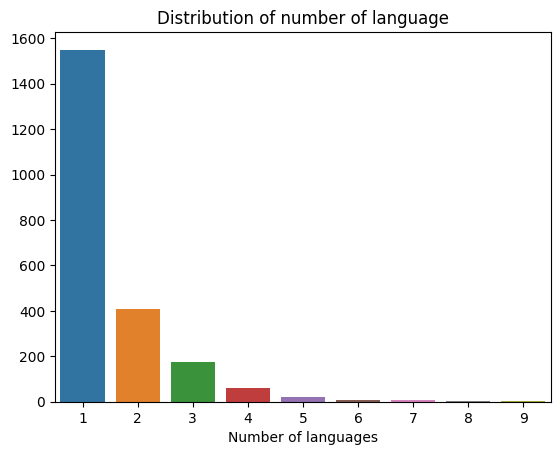

In [43]:
num_lang = df_treated['spoken_languages'].apply(lambda x: len(x)).value_counts()
print(num_lang)
sns.barplot(x=num_lang.index,
            y=num_lang.values)
plt.xlabel('Number of languages')
plt.title('Distribution of number of language')

In [44]:
lang_list = []

for i, row in df_treated.iterrows():
    for lang in row['spoken_languages']:
        lang_list.append(lang['name'])
    
lang_set = set(lang_list)
lang_set

lang_list = list(lang_set)
print("There are {} unique languages in total".format(len(lang_list)))

There are 53 unique languages in total


In [45]:
# Creating a lang_name column first
def lang(col):
    lang_list = []
    for i in col:
        lang_list.append(i['name'])
    return lang_list

df_treated['lang_name'] = df_treated['spoken_languages'].apply(lambda x: lang(x))

In [46]:
# Find out the top 10 common languages in movie:
total_lang = []
for i,row in df_treated.iterrows():
    for x in row['lang_name']:
        total_lang.append(x)
    
Counter(total_lang).most_common(15)

[('English', 2114),
 ('Français', 212),
 ('Español', 194),
 ('Deutsch', 121),
 ('Italiano', 99),
 ('Pусский', 89),
 ('日本語', 62),
 ('普通话', 44),
 ('Português', 38),
 ('العربية', 32),
 ('', 32),
 ('한국어/조선말', 25),
 ('Latin', 22),
 ('广州话 / 廣州話', 21),
 ('Magyar', 20)]

### Exploring status

In [47]:
df_treated.status.value_counts()

Released    2228
Rumored        1
Name: status, dtype: int64

### Exploring keywords

In [48]:
# Creating a keywords_list column first
def keywords(col):
    kw_list = []
    for i in col:
        kw_list.append(i['name'])
    return kw_list

df_treated['keywords_list'] = df_treated['Keywords'].apply(lambda x: keywords(x))

In [49]:
# Find out the top 10 common keywords in movie:
total_kws = []
for i,row in df_treated.iterrows():
    for x in row['keywords_list']:
        total_kws.append(x)
    
Counter(total_kws).most_common(15)

[('woman director', 123),
 ('duringcreditsstinger', 122),
 ('murder', 118),
 ('independent film', 110),
 ('based on novel', 101),
 ('violence', 80),
 ('dystopia', 71),
 ('aftercreditsstinger', 70),
 ('revenge', 66),
 ('sex', 65),
 ('sport', 64),
 ('friendship', 62),
 ('sequel', 58),
 ('police', 58),
 ('suspense', 57)]

### Exploring Cast

In [50]:
# Creating a cast_list column first
def cast(col):
    cast_list = []
    for i in col:
        cast_list.append(i['name'])
    return cast_list

df_treated['cast_list'] = df_treated['cast'].apply(lambda x: cast(x))

In [51]:
# Find out the top 10 common actors/actresses in movie:
total_cast = []
for i,row in df_treated.iterrows():
    for x in row['cast_list']:
        total_cast.append(x)
    
Counter(total_cast).most_common(15)

[('Samuel L. Jackson', 27),
 ('Morgan Freeman', 27),
 ('Robert De Niro', 26),
 ('Bruce Willis', 23),
 ('Bruce McGill', 23),
 ('Liam Neeson', 23),
 ('Jason Statham', 21),
 ('Mel Gibson', 21),
 ('Sigourney Weaver', 21),
 ('Nicolas Cage', 21),
 ('J.K. Simmons', 20),
 ('Sylvester Stallone', 20),
 ('George Clooney', 20),
 ('Forest Whitaker', 20),
 ('Willem Dafoe', 20)]

### Exploring crew

In [52]:
job = []
for i in df_treated.crew[0]:
    job.append(i['job'])

In [53]:
job

['First Assistant Director',
 'Director',
 'Writer',
 'Characters',
 'Producer',
 'Associate Producer',
 'Executive Producer',
 'Executive Producer',
 'Original Music Composer',
 'Director of Photography',
 'Editor',
 'Casting',
 'Production Design',
 'Executive Producer',
 'Script Supervisor',
 'Production Coordinator',
 'Costume Design',
 'Set Decoration',
 'Hair Department Head',
 'Makeup Department Head',
 'Art Direction',
 'Production Supervisor',
 'Sound Re-Recording Mixer',
 'Sound Re-Recording Mixer',
 'Dialogue Editor',
 'Production Sound Mixer',
 'Sound Effects Editor',
 'Stunt Coordinator',
 'Camera Operator',
 'Still Photographer',
 'Rigging Gaffer',
 'Gaffer',
 'Music Supervisor',
 'Music Editor',
 'Music Editor',
 'Costume Supervisor',
 'Steadicam Operator',
 'First Assistant Camera',
 'Supervising Sound Editor',
 'Additional Writing',
 'Hairstylist',
 'Makeup Artist',
 'Makeup Artist',
 'Makeup Artist',
 'Makeup Artist',
 'Hairstylist',
 'First Assistant Director',
 'Gre

In [54]:
# Create a column for Director of the movie:

def director(row):
    for i in row:
        if i['job']=='Director':
            return i['name']
    

df_treated['director'] = df_treated['crew'].apply(lambda x: director(x))

In [55]:
# Create a column for Writer of the movie:

def Writer(row):
    for i in row:
        if i['job']=='Writer':
            return i['name']
    

df_treated['Writer'] = df_treated['crew'].apply(lambda x: Writer(x))

In [56]:
# Create a column for Executive Producer of the movie:

def EP(row):
    EP_list = []
    for i in row:
        if i['job']=='Executive Producer':
            EP_list.append(i['name'])
    return EP_list
    

df_treated['Executive Producer'] = df_treated['crew'].apply(lambda x: EP(x))

In [57]:
df_treated['Executive Producer'].apply(lambda x: len(x)).value_counts()

0     1090
1      405
2      269
3      171
4      135
5       63
6       37
7       23
8       14
9        7
10       5
11       4
13       2
15       1
18       1
14       1
12       1
Name: Executive Producer, dtype: int64

In [58]:
# Reseting the index 
df_treated.reset_index(drop=True,inplace=True)

In [59]:
# Exporting the cleaned dataset for easy reference
df_treated.to_csv('train_cleaned.csv')

In [60]:
df_treated.shape

(2229, 61)

**=======**

In [61]:
df_test1 = df_treated
df_test1.head()

,id,belongs_to_collection,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,with_homepage,collection_or_not,collection_name,genres_name,genre_Adventure,genre_Documentary,genre_Thriller,genre_Science Fiction,genre_Mystery,genre_Horror,genre_Drama,genre_Comedy,genre_Family,genre_Fantasy,genre_Animation,genre_History,genre_Music,genre_Action,genre_Crime,genre_TV Movie,genre_Western,genre_War,genre_Foreign,genre_Romance,genres_count,prod_company_name,prod_company_count,prod_country_name,prod_country_count,release_year,release_month,release_day,release_weekday,lang_name,keywords_list,cast_list,director,Writer,Executive Producer
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",1.400000e+07,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-02-20,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,0,1,Hot Tub Time Machine Collection,[Comedy],0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,"[Paramount Pictures, United Artists, Metro-Gol...",3,[United States of America],1,2015,2,20,4,[English],"[time travel, sequel, hot tub, duringcreditsst...","[Rob Corddry, Craig Robinson, Clark Duke, Adam...",Steve Pink,Josh Heald,"[Rob Corddry, Ben Ormand, Matt Moore]"
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",4.000000e+07,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2004-08-06,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,0,1,The Princess Diaries Collection,"[Comedy, Drama, Family, Romance]",0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,4,[Walt Disney Pictures],1,[United States of America],1,2004,8,6,4,[English],"[coronation, duty, marriage, falling in love]","[Anne Hathaway, Julie Andrews, H√©ctor Elizond...",Garry Marshall,None,[Ellen H. Schwartz]
2,3,0,3.300000e+06,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2014-10-10,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,1,0,0,[Drama],0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"[Bold Films, Blumhouse Productions, Right of W...",3,[United States of America],1,2014,10,10,4,[English],"[jazz, obsession, conservatory, music teacher,...","[Miles Teller, J.K. Simmons, Melissa Benoist, ...",Damien Chazelle,None,"[Jason Reitman, Gary Michael Walters, Jeanette..."
3,9,"[{'id': 256377, 'name': 'The Muppet Collection...",3.440640e+07,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",tt0117110,en,Muppet Treasure Island,After telling the story of Flint's last journe...,6.902423,/5A8gKzOrF9Z7tSUX6xd5dEx4NXf.jpg,"[{'name': 'Walt Disney Pictures',

In [62]:
#Creating a column for each country 

for i in list(country_set):
     df_test1['prod_country_'+str(i)]=df_test1['prod_country_name'].apply(lambda x: 1 if i in x else 0)

In [63]:
list(df_test1.columns)

['id',
 'belongs_to_collection',
 'budget',
 'genres',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'Keywords',
 'cast',
 'crew',
 'revenue',
 'with_homepage',
 'collection_or_not',
 'collection_name',
 'genres_name',
 'genre_Adventure',
 'genre_Documentary',
 'genre_Thriller',
 'genre_Science Fiction',
 'genre_Mystery',
 'genre_Horror',
 'genre_Drama',
 'genre_Comedy',
 'genre_Family',
 'genre_Fantasy',
 'genre_Animation',
 'genre_History',
 'genre_Music',
 'genre_Action',
 'genre_Crime',
 'genre_TV Movie',
 'genre_Western',
 'genre_War',
 'genre_Foreign',
 'genre_Romance',
 'genres_count',
 'prod_company_name',
 'prod_company_count',
 'prod_country_name',
 'prod_country_count',
 'release_year',
 'release_month',
 'release_day',
 'release_weekday',
 'lang_name',
 'keywords_list',
 'cast_list',
 'direct

In [64]:
#Creating a column for each langg 

for i in list(set(total_lang)):
     df_test1['lang_'+str(i)]=df_test1['lang_name'].apply(lambda x: 1 if i in x else 0)
     #print(i)

In [65]:
import collections

type(total_prod_companies)

counts = Counter(total_prod_companies)

# Iterate over the dictionary and print each element followed by its count
for key, value in counts.items():
    print(key, "->", value)

Paramount Pictures -> 147
United Artists -> 39
Metro-Goldwyn-Mayer (MGM) -> 73
Walt Disney Pictures -> 58
Bold Films -> 4
Blumhouse Productions -> 17
Right of Way Films -> 3
Jim Henson Productions -> 1
Jim Henson Company, The -> 1
Castle Rock Entertainment -> 19
Twentieth Century Fox Film Corporation -> 123
Amercent Films -> 1
American Entertainment Partners L.P. -> 2
Interscope Communications -> 6
DreamWorks SKG -> 27
Jinks/Cohen Company -> 1
Double Feature Films -> 7
Jersey Films -> 5
Nina Saxon Film Design -> 2
Cruise/Wagner Productions -> 5
Amblin Entertainment -> 22
Blue Tulip Productions -> 2
Ronald Shusett/Gary Goldman -> 1
Digital Image Associates -> 1
Hypnopolis -> 1
Craven-Maddalena Films -> 3
BenderSpink -> 6
BBC Films -> 24
Headline Pictures -> 1
Magnolia Mae Films -> 2
Taeoo Entertainment -> 1
UK Film Council -> 8
Prescience -> 3
Aegis Film Fund -> 2
Kaleidoscope Films -> 1
Current Entertainment -> 3
TF1 Films Production -> 8
Canal+ -> 31
TPS Star -> 2
EuropaCorp -> 9
Sea 

### We will standard-scale the revenue and budget so as to fix the underfitting of our test data in linear regression

In [66]:
# #import pandas as pd
# from sklearn.preprocessing import StandardScaler

# # Create a StandardScaler instance
# scaler = StandardScaler()

# # Fit and transform the 'revenue' column
# # Reshape is used to convert the column into a 2D array, which is required by the fit_transform() method
# revenue_scaled = scaler.fit_transform(df_test1['revenue'].values.reshape(-1, 1))
# budget_scaled = scaler.fit_transform(df_test1['budget'].values.reshape(-1, 1))

# # Replace the original 'revenue' column with the scaled data
# df_test1['revenue'] = revenue_scaled
# df_test1['budget'] = budget_scaled


# # Check the resulting DataFrame
# print(df_test1.head())

Scaling didn't work, gave weird R-square on test data: -5.8786989729596056e+16
So we will try logarithm

Log didn't work
Min-max didn't work

Some error is pushing the R-square to crazy numbers. (Tushar)

In [67]:
# #Replace the original 'revenue' column with the log data
# df_test1['revenue'] = np.log(df_test1['revenue'])
# df_test1['budget'] = np.log(df_test1['budget'])

# min_budget = df_test1['budget'].min()
# max_budget = df_test1['budget'].max()

# Normalize the 'budget' column using Min-Max scaling
# df_test1['budget'] = (df_test1['budget'] - min_budget) / (max_budget - min_budget)


# min_revenue = df_test1['revenue'].min()
# max_revenue = df_test1['revenue'].max()

# # Normalize the 'revenue' column using Min-Max scaling
# df_test1['revenue'] = (df_test1['revenue'] - min_revenue) / (max_revenue - min_revenue)

In [68]:
# Check the resulting DataFrame
print(df_test1['budget'].head())

0    1.400000e+07
1    4.000000e+07
2    3.300000e+06
3    3.440640e+07
4    6.000000e+06
Name: budget, dtype: float64


In [69]:
df_test1.iloc[:,:99].head()

,id,belongs_to_collection,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,with_homepage,collection_or_not,collection_name,genres_name,genre_Adventure,genre_Documentary,genre_Thriller,genre_Science Fiction,genre_Mystery,genre_Horror,genre_Drama,genre_Comedy,genre_Family,genre_Fantasy,genre_Animation,genre_History,genre_Music,genre_Action,...,Writer,Executive Producer,prod_country_New Zealand,prod_country_Russia,prod_country_Spain,prod_country_Greece,prod_country_Argentina,prod_country_Bahamas,prod_country_Czech Republic,prod_country_Norway,prod_country_Austria,prod_country_Pakistan,prod_country_Costa Rica,prod_country_Netherlands,prod_country_United Kingdom,prod_country_Philippines,prod_country_Hong Kong,prod_country_Denmark,prod_country_Ireland,prod_country_Malta,prod_country_Iran,prod_country_Brazil,prod_country_Serbia and Montenegro,prod_country_Belgium,prod_country_Peru,prod_country_France,prod_country_Algeria,prod_country_Namibia,prod_country_Italy,prod_country_Cambodia,prod_country_Japan,prod_country_Uruguay,prod_country_United Arab Emirates,prod_country_China,prod_country_Mexico,prod_country_Israel,prod_country_Indonesia,prod_country_Morocco,prod_country_Hungary,prod_country_Qatar
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",1.400000e+07,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-02-20,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,0,1,Hot Tub Time Machine Collection,[Comedy],0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,Josh Heald,"[Rob Corddry, Ben Ormand, Matt Moore]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",4.000000e+07,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2004-08-06,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,0,1,The Princess Diaries Collection,"[Comedy, Drama, Family, Romance]",0,0,0,0,0,0,1,1,1,0,0,0,0,0,...,None,[Ellen H. Schwartz],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,3.300000e+06,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2014-10-10,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,1,0,0,[Drama],0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,None,"[Jason Reitman, Gary Michael Walters, Jeanette...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,"[{'id': 256377, 'name': 'The Muppet Collection...",3.440640e+07,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",tt0117110,en,Muppet Tre

In [70]:
df_test1.groupby('original_language').agg({'revenue':np.mean}).sort_values(by='revenue',ascending=False)

,revenue
original_language,
en,8.696687e+07
zh,5.023854e+07
sv,3.889053e+07
ja,3.812678e+07
it,2.895550e+07
cn,2.696453e+07
da,2.604347e+07
fr,2.344289e+07
de,2.134362e+07


In [71]:
list(genre_set)
df_test1_Fan = df_test1[df_test1['genre_Fantasy']==1]
df_test1_Fan.revenue.mean()

161327839.83163264

In [72]:
gen_rev_list = {}
def genre_revnue(list):
    for i in list:
        gen_rev_list[i] = df_test1[df_test1['genre_'+str(i)]==1].revenue.mean().round(2)
    return print(gen_rev_list)

In [73]:
genre_revnue(list(genre_set))

{'Adventure': 198931419.67, 'Documentary': 7051560.82, 'Thriller': 76529963.82, 'Science Fiction': 133026448.83, 'Mystery': 67337185.55, 'Horror': 56612680.58, 'Drama': 56863148.92, 'Comedy': 75006717.95, 'Family': 166729757.08, 'Fantasy': 161327839.83, 'Animation': 179163935.67, 'History': 44556241.09, 'Music': 46541612.05, 'Action': 125234081.43, 'Crime': 64521922.79, 'TV Movie': 42000000.0, 'Western': 58432188.36, 'War': 59301561.39, 'Foreign': 1085152.83, 'Romance': 65812625.57}


In [74]:
{k: v for k, v in sorted(gen_rev_list.items(), key=lambda item: item[1],reverse=True)}

{'Adventure': 198931419.67,
 'Animation': 179163935.67,
 'Family': 166729757.08,
 'Fantasy': 161327839.83,
 'Science Fiction': 133026448.83,
 'Action': 125234081.43,
 'Thriller': 76529963.82,
 'Comedy': 75006717.95,
 'Mystery': 67337185.55,
 'Romance': 65812625.57,
 'Crime': 64521922.79,
 'War': 59301561.39,
 'Western': 58432188.36,
 'Drama': 56863148.92,
 'Horror': 56612680.58,
 'Music': 46541612.05,
 'History': 44556241.09,
 'TV Movie': 42000000.0,
 'Documentary': 7051560.82,
 'Foreign': 1085152.83}

In [93]:
lang_rev_list = {}
def lang_revnue(list):
    for i in list:
        lang_rev_list[i] = df_test1[df_test1['lang_'+str(i)]==1].revenue.mean().round(2)
    return print(lang_rev_list)

In [95]:
lang_revnue(list(total_lang))

{'English': 85489207.57, 'Pусский': 99405977.84, 'svenska': 183396133.55, 'Srpski': 34815105.25, 'Deutsch': 85903072.95, 'Français': 83791081.3, 'Italiano': 92438602.03, '日本語': 74913685.4, 'العربية': 109154617.22, 'עִבְרִית': 110156917.0, 'Português': 66596119.87, 'Latin': 168090035.36, '普通话': 124734551.64, '한국어/조선말': 75673571.2, 'Español': 87691769.53, '': 97666952.38, '广州话 / 廣州話': 86889493.67, 'Magyar': 29869755.8, 'ελληνικά': 132796136.71, 'Gaeilge': 107801730.5, 'فارسی': 83890227.14, 'ภาษาไทย': 118253320.56, 'Polski': 30424116.93, 'हिन्दी': 27427036.93, 'Türkçe': 47752949.67, 'Dansk': 56553054.33, 'Český': 38737798.24, 'Afrikaans': 148516424.25, 'български език': 110146320.5, 'Kiswahili': 96266092.86, 'Norsk': 14316970.17, 'No Language': 2607319.17, 'اردو': 83912719.14, 'shqip': 75245518.0, 'Română': 32218272.0, 'Bahasa indonesia': 4927123.5, 'Tiếng Việt': 95894285.62, 'Slovenčina': 191185897.0, 'Nederlands': 25640024.0, 'Esperanto': 69952683.0, 'euskera': 12102741.5, 'தமிழ்': 1965

In [96]:
{k: v for k, v in sorted(lang_rev_list.items(), key=lambda item: item[1],reverse=True)}

{'Íslenska': 279671461.0,
 'Eesti': 225990978.0,
 'Slovenčina': 191185897.0,
 'svenska': 183396133.55,
 'Latin': 168090035.36,
 'Afrikaans': 148516424.25,
 'suomi': 133000000.0,
 'ελληνικά': 132796136.71,
 '普通话': 124734551.64,
 'ภาษาไทย': 118253320.56,
 'עִבְרִית': 110156917.0,
 'български език': 110146320.5,
 'العربية': 109154617.22,
 'Gaeilge': 107801730.5,
 'isiZulu': 107555788.0,
 'Pусский': 99405977.84,
 '': 97666952.38,
 'Kiswahili': 96266092.86,
 'Tiếng Việt': 95894285.62,
 'Italiano': 92438602.03,
 'Український': 89439947.75,
 'Español': 87691769.53,
 '广州话 / 廣州話': 86889493.67,
 'Deutsch': 85903072.95,
 'English': 85489207.57,
 'اردو': 83912719.14,
 'فارسی': 83890227.14,
 'Français': 83791081.3,
 '한국어/조선말': 75673571.2,
 'shqip': 75245518.0,
 '日本語': 74913685.4,
 'پښتو': 73276047.0,
 'Esperanto': 69952683.0,
 'Português': 66596119.87,
 'Dansk': 56553054.33,
 'Hrvatski': 55169850.5,
 'Türkçe': 47752949.67,
 'Somali': 42778657.33,
 'ਪੰਜਾਬੀ': 40222820.5,
 'Český': 38737798.24,
 'Srps

In [102]:
df_test1[df_test1['lang_Eesti']==1][['title','genres_name','revenue','spoken_languages']]

,title,genres_name,revenue,spoken_languages
1470,Yes Man,[Comedy],225990978,"[{'iso_639_1': 'et', 'name': 'Eesti'}, {'iso_6..."


In [100]:
list(df_test1.columns)

['id',
 'belongs_to_collection',
 'budget',
 'genres',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'Keywords',
 'cast',
 'crew',
 'revenue',
 'with_homepage',
 'collection_or_not',
 'collection_name',
 'genres_name',
 'genre_Adventure',
 'genre_Documentary',
 'genre_Thriller',
 'genre_Science Fiction',
 'genre_Mystery',
 'genre_Horror',
 'genre_Drama',
 'genre_Comedy',
 'genre_Family',
 'genre_Fantasy',
 'genre_Animation',
 'genre_History',
 'genre_Music',
 'genre_Action',
 'genre_Crime',
 'genre_TV Movie',
 'genre_Western',
 'genre_War',
 'genre_Foreign',
 'genre_Romance',
 'genres_count',
 'prod_company_name',
 'prod_company_count',
 'prod_country_name',
 'prod_country_count',
 'release_year',
 'release_month',
 'release_day',
 'release_weekday',
 'lang_name',
 'keywords_list',
 'cast_list',
 'direct

===============

## Creating the dataframe for model training (Simple approach: just keep those columns that is numerical and discarding those that are not)

In [76]:
# These are the columns we wish to include in the training dataset
int_cols = list(df_test1.dtypes[df_test1.dtypes=='int64'].index)
float_cols = list(df_test1.dtypes[df_test1.dtypes=='float64'].index)


total_cols = int_cols+float_cols


In [77]:
# Filtering the dataset to contain just the columns we want
df_train = df_test1[total_cols]
# in fact we do not need the 'id' column, so we remove it as well
df_train = df_train.drop('id',axis=1)

In [78]:
df_train.shape

(2229, 149)

In [79]:
X = df_train.drop('revenue',axis=1)

In [80]:
y = df_train['revenue']

In [81]:
print(y.head())

0    12314651
1    95149435
2    13092000
3    34327391
4    18750246
Name: revenue, dtype: int64


## Cross Validation with XGBoost

In [82]:
# instantiate a XGB Regressor
rt = xgb.XGBRegressor(max_depth=5)

# Create a scorer
mae_scorer = make_scorer(mean_absolute_error)

# perform cross validation
cross_val_scores = cross_val_score(rt,X,y,scoring=mae_scorer,cv=3)

In [83]:
print(cross_val_scores)

[50061387.16997708 51061308.44963408 49966237.53617093]


In [84]:
print("The average mean absolute error is ${}".format(cross_val_scores.mean().round(2)))

The average mean absolute error is $50362977.72


## Perform hyperparameter tuning

In [85]:
param_grid = {'learning_rate':['none',0.05,1,0.05],
              'n_estimators':range(50,200,50),
              'max_depth':[3,5,7,10]}
              
              
randomized_xgb = RandomizedSearchCV(rt,
                                      param_distributions=param_grid,
                                      n_iter=10,
                                      cv=3,
                                      scoring=mae_scorer,
                                      verbose=1
                                      )

randomized_xgb.fit(X,y)

print(randomized_xgb.best_estimator_)
print(randomized_xgb.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='', learning_rate=1,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=7,
             max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)
63680387.48057916


It seems that the original XGBoost setting provided the best result. Take a look at the hyperparameters

In [86]:
rt.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)>

## Trying linear regression too. Will split the train.csv content.

In [87]:
# Assuming X is a pandas dataframe containing the features and y is a pandas series containing the target variable

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Linear Regression model
linear_regression = LinearRegression()

# Fit the model using the training data
linear_regression.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = linear_regression.predict(X_test)

# Evaluate the model using various performance measures
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
r2 = r2_score(y_test, y_pred)  # R-squared

# Print the performance measures
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)



Mean Squared Error (MSE): 4.457934490663248e+22
Root Mean Squared Error (RMSE): 211138212805.33868
Mean Absolute Error (MAE): 24941728059.73166
R-squared: -1918811.8288424392


Checking similar metrics for the training data, to compare things like overfitting

In [88]:
# Make predictions on the training data
yt_pred = linear_regression.predict(X_train)

# Evaluate the model using various performance measures
mse_train = mean_squared_error(y_train, yt_pred)  # Mean Squared Error
rmse_train = np.sqrt(mse_train)  # Root Mean Squared Error
mae_train = mean_absolute_error(y_train, yt_pred)  # Mean Absolute Error
r2_train = r2_score(y_train, yt_pred)  # R-squared

# Print the performance measures
print("Mean Squared Error for training data (MSE):", mse_train)
print("Root Mean Squared Error for training data (RMSE):", rmse_train)
print("Mean Absolute Error for training data (MAE):", mae_train)
print("R-squared for training data:", r2_train)

Mean Squared Error for training data (MSE): 6888204812952298.0
Root Mean Squared Error for training data (RMSE): 82995209.57833831
Mean Absolute Error for training data (MAE): 53831269.2320239
R-squared for training data: 0.692385743286676


Let's also get the _coefficients_ of lin reg:

In [89]:
# Extract the coefficients from the fitted model
coefficients = linear_regression.coef_

# Create a DataFrame to display the coefficients along with their corresponding feature names
feature_coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

# Calculate the sum of coefficients for features starting with "prod_country_" and "lang_"
prod_country_sum = feature_coeff_df[feature_coeff_df['Feature'].str.startswith('prod_country_')]['Coefficient'].sum()
lang_sum = feature_coeff_df[feature_coeff_df['Feature'].str.startswith('lang_')]['Coefficient'].sum()
genre_sum = feature_coeff_df[feature_coeff_df['Feature'].str.startswith('genre_')]['Coefficient'].sum()

# Create a new DataFrame for the summed up coefficients
summed_coeff_df = pd.DataFrame({
    'Feature': ['prod_country_sum', 'lang_sum', 'genre_sum'],
    'Coefficient': [prod_country_sum, lang_sum, genre_sum]
})

# Append the summed coefficients to the feature_coeff_df DataFrame
feature_grp_imp_df = feature_coeff_df.append(summed_coeff_df, ignore_index=True)

# Filter out the features starting with "prod_country_" and "lang_"
feature_grp_imp_df = feature_grp_imp_df[~feature_grp_imp_df['Feature'].str.startswith(('prod_country_', 'lang_', 'genre_'))]

# Print the feature_grp_imp_df DataFrame
print(feature_grp_imp_df)

                Feature   Coefficient
0         with_homepage  3.296519e+07
1     collection_or_not  6.813562e+07
22         genres_count  6.138175e+12
23   prod_company_count -2.199536e+06
25         release_year -6.689870e+04
26        release_month -2.998943e+04
27          release_day  1.699183e+05
28      release_weekday -4.696456e+06
145              budget  2.119141e+00
146          popularity  3.532012e+06
147             runtime  9.415847e+05


### It seems like linear regression is underfitting our test data
So using Ridge regression and GridSearchCV for hyperparameter optimization:

In [90]:


# Create a Ridge regression model
ridge_model = Ridge()

# Define the hyperparameter values to search
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create a GridSearchCV instance
grid_search = GridSearchCV(ridge_model, param_grid, scoring='r2', cv=5)

# Fit the GridSearchCV instance on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Evaluate the model with the best hyperparameters on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R-squared for hyperparams optimization:", r2)

Best hyperparameters: {'alpha': 10}
R-squared for hyperparams optimization: 0.5612925650803282
